## Simulation of the Heston model using the Quadratic exponential scheme

In order to achieve maximum performance of Pytorch in a Monte-Carlo simulation it is critical to vectorize over the number of simulations. Thus we need to remove all 'if' statements from the Quadratic Exponential scheme. Here we are also comparing the numerical performance with a standard Milstein-Euler scheme

In [1]:
import torch
import numpy as np
from quant_analytics_torch.analytics import blackanalytics
from icecream import ic
from quant_analytics_torch.calculators.multivariatebrownianbridge import MultivariateBrownianBridge
from quant_analytics_torch.analytics.norminv import norminv, cumnorm
import matplotlib
from matplotlib import pyplot as plt
from quant_analytics_torch.analytics import maxsoft
from quant_analytics_torch.analytics.characteristicfunction import heston_option_price

In [2]:
def milstein_euler_simulation(rho, theta, kappa, eta, T, paths, n_dt):
    dt = T/n_dt
    dim = n_dt
    sobol_engine =  torch.quasirandom.SobolEngine(2*dim)
    x = sobol_engine.draw(1)
    u = sobol_engine.draw(paths,dtype=torch.float64)

    states = 2
    dim = n_dt

    fm = torch.zeros(size=(states,states))

    fm[0][0] = 1.
    fm[0][1] = rho
    fm[1][0] = rho
    fm[1][1] = 1.
    fwd_cov = torch.zeros(size=(dim, states, states))

    for i in range(dim):
        fwd_cov[i] = fm

    multivariate_brownian = MultivariateBrownianBridge(fwd_cov)

    y = norminv(u)
    y = torch.reshape(y, shape=(dim,states,paths))

    dz = multivariate_brownian.path(y, True)

    X = torch.zeros([paths])
    V = torch.zeros([n_dt+1,paths])
    Vt = torch.zeros([paths])
    Vt[:] = theta
    V[0] = theta

    for i in range(n_dt):
        z2 = dz[i][1]
        z1 = dz[i][0]
        Vt = torch.maximum((Vt + kappa*theta*dt + eta*torch.sqrt(Vt*dt)*z2+0.25*eta*eta*dt*(z2*z2-1.))/(1+kappa*dt),torch.tensor(0.))
        X = X - V[i]*dt/2 + torch.sqrt(V[i]*dt)*z1
        V[i+1] = Vt
    return X

In [3]:
def quadratic_exponential(rho, theta, kappa, eta, T, paths, n_dt):
    dt = T/n_dt
    dim = n_dt

    rhobar = torch.sqrt(1.-rho*rho)
    gamma1 = 0.5
    gamma2 = 0.5

    K0 = -(rho*kappa*theta)*dt/eta
    K1 = gamma1*dt*(-0.5+(kappa*rho/eta))-(rho/eta)
    K2 = gamma2*dt*(-0.5+(kappa*rho/eta))+(rho/eta)
    K3 = gamma1*dt*(1-rho**2)
    K4 = gamma2*dt*(1-rho**2)
    
    sobol_engine =  torch.quasirandom.SobolEngine(2*dim)
    x = sobol_engine.draw(1)
    u = sobol_engine.draw(paths,dtype=torch.float64)

    u = torch.transpose(u,0,1)

    states = 2
    dim = n_dt
    fm = torch.zeros(size=(states,states))

    fm[0][0] = 1.
    fm[0][1] = rho
    fm[1][0] = rho
    fm[1][1] = 1.        
    fwd_cov = torch.zeros(size=(dim, states, states))

    for i in range(dim):
        fwd_cov[i] = fm

    multivariate_brownian = MultivariateBrownianBridge(fwd_cov)

    y = norminv(u)
    y = torch.reshape(y, shape=(dim,states,paths))

    dz = multivariate_brownian.path(y, True)

    X = torch.zeros([paths])
    V = torch.zeros([n_dt+1,paths])
    Vt = torch.zeros([paths])
    Vt[:] = theta
    V[0] = theta

    for i in range(n_dt):
        # Decorrelate the Gaussian variables
        #
        # Q = ([[rho_bar, rho],[0,1]])
        #
        # inv(Q) = ([[1/rho_bar, -rho/rho_bar, 0, 1]])
        #
        # inv(Q)*dz[i]
        #
        # see "Efficient Simulation of the multi-asset Heston model", Innocentis, M.D., et. al.
        #
        z2 = (dz[i][1]-rho*dz[i][0])/rhobar
        z1 = dz[i][0]
        # QE simulation scheme
        minusexpkappadt = torch.exp(-kappa*dt)
        m = theta+( Vt - theta) * minusexpkappadt
        s2 = ((Vt*eta**2) * minusexpkappadt/kappa)*(1-minusexpkappadt) + ( theta*eta**2)*((1-minusexpkappadt)**2)/(2*kappa)
        phi = s2/m**2
        #
        # Calculate the lower branch
        #
        psi_2 = 2/phi
        b2 = torch.maximum(psi_2-1+(torch.sqrt(psi_2))*(torch.sqrt(torch.maximum(psi_2-1, torch.tensor(0.)))),torch.tensor(0.))
        a = m/(1+b2)
        Vnew_1 = a*(z2 + torch.sqrt(b2))**2
        #
        # Calulcate the upper branch
        #
        p = (phi-1)/(phi+1)
        beta = (1-p)/m
        Vnew_2 = torch.log((1-p)/(1-cumnorm(z2))) / beta
        Vnew_2 = torch.maximum(Vnew_2, torch.tensor(0.))
        phiC = 1.5
        #
        # Switch the branches
        #
        p_1 = maxsoft.soft_heavy_side_hyperbolic(phiC-phi, 0.00001)
        q_1 = 1. - p_1
        Vt = p_1 * Vnew_1 + q_1 * Vnew_2
        V[i+1] = Vt
        #
        # Update the underlying
        #
        X = X + K0 + K1*V[i] + K2*Vt + (torch.sqrt(K3*V[i]+K4*Vt))*z1

    return X


In [26]:
rho = torch.tensor(-0.67829, requires_grad=True)
theta = torch.tensor((0.3095)**2, requires_grad=True)
kappa = torch.tensor(0.8, requires_grad=True)
eta= torch.tensor(0.9288, requires_grad=True)

T = 1
paths =2**14-1
n_dt = 32

In [27]:
X_milstein = milstein_euler_simulation(rho, theta, kappa, eta, T, paths, n_dt)

In [28]:
X_qe = quadratic_exponential(rho, theta, kappa, eta, T, paths, n_dt)

In [29]:
Sm = torch.exp(X_milstein)
Sq = torch.exp(X_qe)
Savg = torch.mean(Sm)
Pavg = torch.mean(torch.maximum(Sm-1.,torch.tensor(0.)))
print(Savg)
print(Pavg)

tensor(1.0009, grad_fn=<MeanBackward0>)
tensor(0.1014, grad_fn=<MeanBackward0>)


In [30]:
nk = 31
k = np.linspace(0.5,1.8,nk)
ivm = torch.zeros(nk)
ivq = torch.zeros(nk)
ivh = torch.zeros(nk)

for it,ik in enumerate(k):
    pm = torch.mean(torch.maximum(Sm-ik,torch.tensor(0.))).detach().numpy()
    ivm[it] = blackanalytics.impliedvolatility(pm, 1., ik, T)
    pq = torch.mean(torch.maximum(Sq-ik,torch.tensor(0.))).detach().numpy()
    ivq[it] = blackanalytics.impliedvolatility(pq, 1., ik, T)
    ph = heston_option_price(ik, 1., theta.detach().numpy(), kappa.detach().numpy(), theta.detach().numpy(), eta.detach().numpy(), rho.detach().numpy(), T)
    ivh[it] = blackanalytics.impliedvolatility(ph, 1., ik, T)

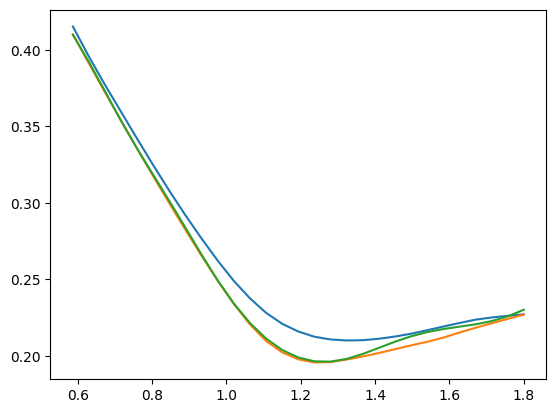

Bad pipe message: %s [b"\xf4\xd7\xa2\xc4'\x03RO\xc4WTmO+\x88JZt (4\xf4'@\x9f(\xb0}\xfb_\x80\x93\xdei%\xde\x97>\xa8v\n\xd9\xca\x9b3\xac%|\xf9W\xbf\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01"]
Bad pipe message: %s [b')y\x9f\xc5\x90\xfc\xc4D\x86\xa4\xd6\x93\xb7\x7f\xd7\xb6\x97"\x00\x00\xf4\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00\xa7\x00m\x00:\x00\x89\xc02\xc0.\xc0*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\x00\x84\xc0/\xc0+\xc0\'\xc0#\xc0\x13\xc0\t\x00\xa4\x00\xa2\x00\xa0\x00\x9e\x00g\x00@\x00?\x00>\x003\x002\x001\x000\x00\x9a\x00\x99\x00\x98\x00\x97\x00E']
Bad pipe message: %s [b"\x93\xa3328{\xda\xceK\x85\xd90w\xa1\xf9)\xbb\x8b \xd7s\n\xfeN\xb3'\xf8\xefQv\xb6\xce\xc2\x1di\xf8\xce\xb4\xa2\r\xbb\x03\x93Q\x8a\x83\xf0\xde\xc0f\xd7\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1

In [31]:
plt.plot(k,ivm)
plt.plot(k,ivq)
plt.plot(k,ivh)